**To be done:**

*important*
* test already established models
* model evaluation, include confusion matrices
* visualization of filter training
* ...

*optional*
* rethink PCA, Auto encoders
* get the validation standard errors

**packages**

In [1]:
import numpy as np 
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


**python version 3.6**

In [2]:
!python -V

Python 3.6.6 :: Anaconda, Inc.


In [3]:
path="../input/"
train_file = path + "fashion-mnist_train.csv"
test_file  = path + "fashion-mnist_test.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

* we would like to merge the two datasets because we are not sure if the data has been shuffled.

In [4]:
data_full=pd.concat([train_data,test_data])
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 419.8 MB


In [5]:
data_full.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


**Inputs**

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below. 

**Labels**

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot.

In [6]:
class_dict={0:"tshirt",1:"trouser",2:"pullover",3:"dress",4:"coat",5:"sandal",6:"shirt",7:"sneaker",8:"bag",9:"ankle_boot"}
print(class_dict)

{0: 'tshirt', 1: 'trouser', 2: 'pullover', 3: 'dress', 4: 'coat', 5: 'sandal', 6: 'shirt', 7: 'sneaker', 8: 'bag', 9: 'ankle_boot'}


* as a first step we normalize the pixel values to fall into the interval $[0,1]$

In [7]:
data_full.iloc[:, 1:] = data_full.iloc[:, 1:] / 255
data_full.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,0.000000,0.411765,0.360784,0.396078,0.419608,0.392157,0.517647,0.000000,0.000000,0.007843,0.015686,0.0,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.588235,...,0.827451,0.862745,0.839216,0.290196,0.000000,1.000000,0.870588,0.501961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172549,0.047059,0.0,0.0,0.156863,0.525490,0.635294,0.749020,0.839216,0.639216,0.572549,0.647059,0.309804,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,0.447059,0.717647,0.439216,0.215686,0.090196,0.282353,0.400000,0.647059,0.627451,0.109804,0.000000,0.0,0.000000,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.094118,0.737255,0.639216,0.364706,...,0.670588,0.976471,0.811765,0.772549,0.792157,0.176471,0.000000,0.011765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003922,0.0,0.0,0.000000,0.086275,0.082353,0.098039,0.270588,0.203922,0.176471,0.290196,0.152941,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.180392,0.000000,0.082353,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.098039,0.733333,0.741176,...,0.901961,0.929412,0.898039,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.266667,0.454902,0.439216,0.533333,0.576471,0.564706,0.474510,0.400000,0.247059,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


**data exploration**

**1. Labels**

In [8]:
X_all = np.array(data_full.iloc[:, 1:])
y_all = np.array(data_full.iloc[:, 0])

* checking for class inbalances.

Text(0, 0.5, 'class count')

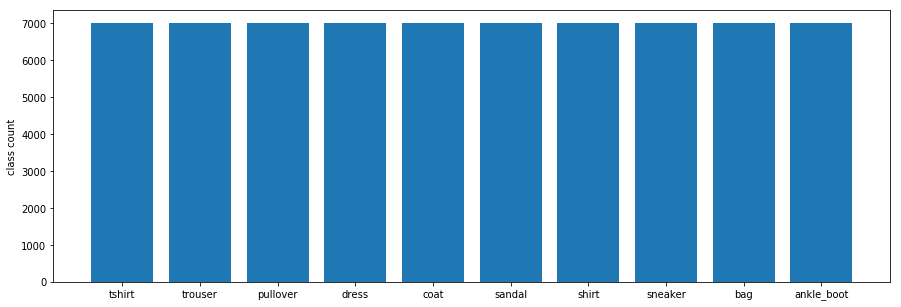

In [9]:
unique, counts = np.unique(y_all,return_counts=True)
products=[class_dict[i] for i in unique]
plt.figure(figsize=(15,5))
plt.bar(products,counts)
plt.ylabel("class count")

* each class has 7k observations in the entire dataset

**2. Input images**

* reconstruct images

In [10]:
X_all_2d = X_all.reshape(X_all.shape[0], 28, 28)

**Sample Images:**

showing an images of each product type

In [11]:
_ ,index=np.unique(y_all,return_index=True)

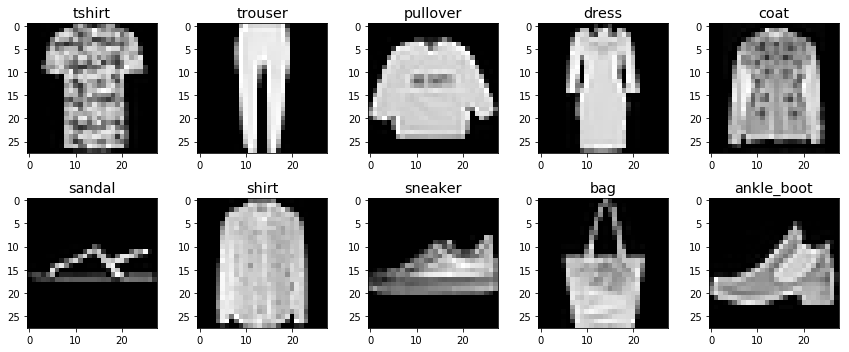

In [12]:
plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(class_dict[i],fontsize="x-large")
    plt.imshow(X_all_2d[index[i]], cmap='gray')
    plt.tight_layout()

**TBD: Dimensionality reduction**

**TBD: PCA**

https://www.kaggle.com/residentmario/dimensionality-reduction-and-pca-for-fashion-mnist

**TBD: Autoencoding**

**DATA SPLITTING**

we are splitting the total dataset into training data and a testset. In order to do so we need array formats. Samples are randomly assigned to training and test set with the random seed 708145.

In [13]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=708145)

Our motivation is to use a validation set and cross validation to find the ideal set of hyperparameters. 

Background for Cross-Validation (CV):
1. using the hold-out set approach (a single validation set) will not yield an estimate of the validation metric standard errors. By using a single repetition of cross validation, an estimate of the validation metric error can be obtained. 

**Take away:** Getting standard errors is a additional information provided by CV.
2. The variance of the final validation metric is smaller when is is calculated as the average of all performances on the different validation sets during CV rather than if it is obtained from only one validation set. The variance of the validation metric can be determined by repeating k-fold CV several times. The determined variance is an estimate of the true variance of the generalization error. 

**Take away:** Averaging is better than not averaging with respect to the variance of the validation metric.

3. There is a tradeoff that needs to be considered when selecting the optimal number of folds (the value of k). Firstly, the larger the number of folds, the less biased is the calculated validation metric towards the generalization error. Reason, a larger number of k results in smaller validation sets per fold such that more observations are included in each train set, which leads to better estimates. Secondly, the smaller the number of folds, the smaller the variance of the validation metric. Reason, a smaller number of folds means that less oberservations are included in each train set, which means that individual trainsets are less correlated with each other in CV. In turn, the variance of a validation metric that is caluclated as the average of rather uncorrelated train sets is smaller than the variance of the same validation metric that is calculates as the average of more correlated train sets. We are using 10 folds as it is a commonly used value.

**Take away:** While averaging helps to reduce variance, the correlation of the train sets is important to consider too.

4. The larger k is chosen the more computationally expensive is the training.

*Source: Introduction to Statistical Learning p. 183*

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_002.png)

In [14]:
from sklearn.model_selection import KFold

In [15]:
k = 2
kfold = KFold(n_splits=k, shuffle=True, random_state=708145)

**1. SIMPLE 2-LAYER CNN**

we use a very simple CNN with two Convolutional layers and two Dense layers. The optimizer is Adagrad. No hyperparameter tuning is conducted here. We use early stopping and the optimizer Adadelta.

Total parameters 225k


In [16]:
def gen_cnn ():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [17]:
callback=[EarlyStopping(monitor='loss', patience=5)]

we have to change X such that it is compatible with the CNN. There are four dimensions for the image values, the number of images, the number of pixels in height, the number of pixels across and the 1 because the images are in greyscale.

In [18]:
X_train_full = X_train_full.reshape(X_train_full.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [19]:
cv_scores = []
for train_index, val_index in kfold.split(X_train_full,y_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]
    y_train, y_val = keras.utils.to_categorical(y_train, 10), keras.utils.to_categorical(y_val, 10)
    model = gen_cnn()
    print (" - NEW CV-split")
    model.fit(X_train, y_train, epochs=500, callbacks=callback,batch_size=128,verbose=2) 
    _, acc = model.evaluate(X_val, y_val, verbose = 2)
    cv_scores.append(acc)

Instructions for updating:
Colocations handled automatically by placer.
 - NEW CV-split
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 3s - loss: 0.6662 - acc: 0.7645
Epoch 2/500
 - 1s - loss: 0.4168 - acc: 0.8514
Epoch 3/500
 - 1s - loss: 0.3645 - acc: 0.8674
Epoch 4/500
 - 1s - loss: 0.3295 - acc: 0.8800
Epoch 5/500
 - 1s - loss: 0.3069 - acc: 0.8895
Epoch 6/500
 - 1s - loss: 0.2848 - acc: 0.8970
Epoch 7/500
 - 1s - loss: 0.2678 - acc: 0.9034
Epoch 8/500
 - 1s - loss: 0.2495 - acc: 0.9090
Epoch 9/500
 - 1s - loss: 0.2327 - acc: 0.9161
Epoch 10/500
 - 1s - loss: 0.2213 - acc: 0.9189
Epoch 11/500
 - 1s - loss: 0.2040 - acc: 0.9261
Epoch 12/500
 - 1s - loss: 0.1931 - acc: 0.9293
Epoch 13/500
 - 1s - loss: 0.1813 - acc: 0.9345
Epoch 14/500
 - 1s - loss: 0.1720 - acc: 0.9370
Epoch 15/500
 - 1s - loss: 0.1571 - acc: 0.9428
Epoch 16/500
 - 1s - loss: 0.1461 - acc: 0.9478
Epoch 17/500
 - 1s - loss: 0.1364 - acc: 0.9500
Epoch 18/500
 - 1s - loss: 0.1243 - acc: 0.9555
Epoch 19/

In [20]:
print(cv_scores)

[0.9046071428571428, 0.8999285714285714]


**2. ADOPTED COMPLEX MODEL**

Select a pretrained network...

network examples: https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/

**MODEL EVALUATION**

In [21]:
model = gen_cnn()
history = model.fit(X_train_full, y_train_full, epochs=200, callbacks=callback,batch_size=128,verbose=2) 
score = model.evaluate(X_test, y_test)

ValueError: Error when checking target: expected dense_6 to have shape (10,) but got array with shape (1,)